In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

In [2]:
default = [0,0,0,0]

images = []
annotations = []
for path in tqdm(os.listdir('../input/face-mask-detection/annotations')):
    
    
    tree = ET.parse(os.path.join('../input/face-mask-detection/annotations',path))
    root = tree.getroot()
    
    imgpath = os.path.join('../input/face-mask-detection/images',path[:-4]+'.png')
    image = cv2.imread(imgpath)
    height,width = image.shape[:2]
    
    
    
    flag = False
    labels = []
    notations = []
    
    for i,neighbor in enumerate(root.iter('bndbox')):
        xmin = int(neighbor.find('xmin').text)/width 
        ymin = int(neighbor.find('ymin').text)/height 
        xmax = int(neighbor.find('xmax').text)/width 
        ymax = int(neighbor.find('ymax').text)/height 
        notations.append([xmin,ymin,xmax,ymax])
        if i==5:
            flag = True
            break
    for i in range(i,4):
        notations.append(default)
    
    
    if not flag:
        annotations.append(notations)
        image = cv2.resize(image,(500,500))
        images.append(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    


  0%|          | 0/853 [00:00<?, ?it/s]

In [3]:
images = np.array(images)
images = images/255

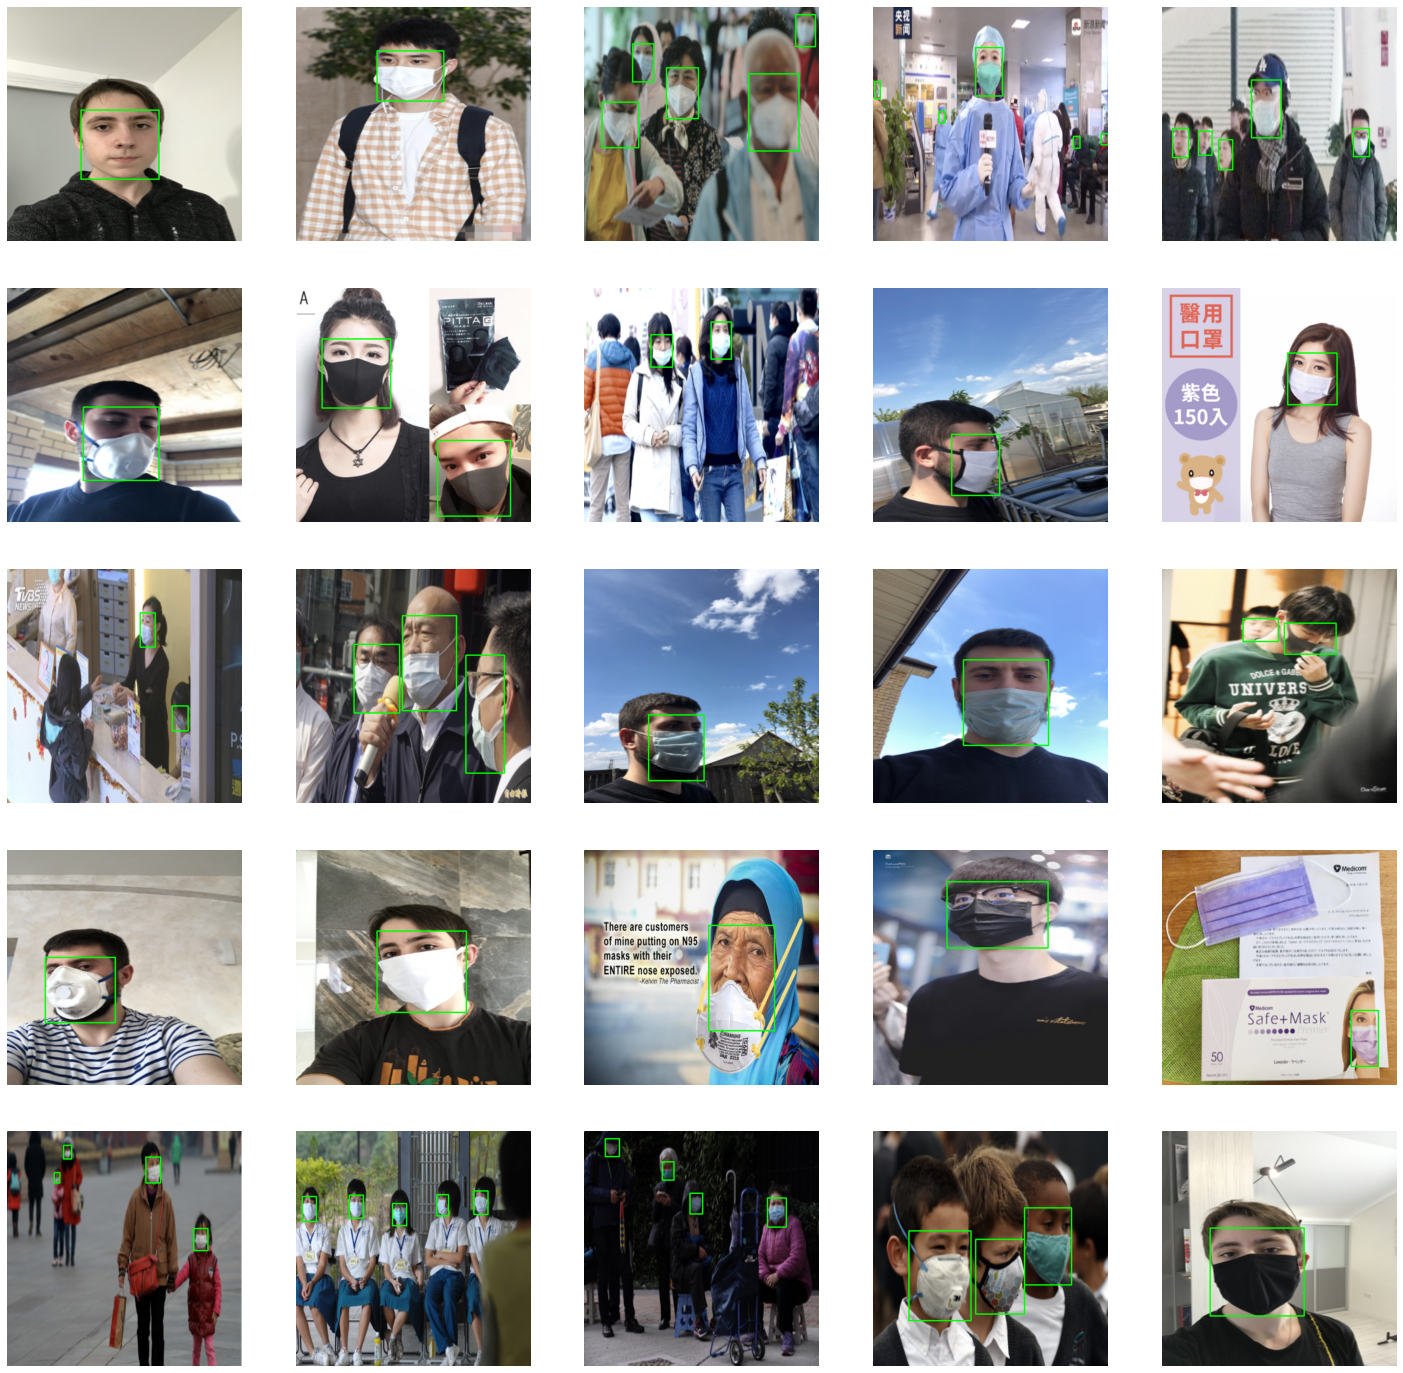

In [4]:

plt.figure(figsize=(25,25))
start = 0
end = 25
for i,img in enumerate(images[start:end].copy()):
    plt.subplot(5,5,i+1)
    for notations in annotations[start]:
        [xmin,ymin,xmax,ymax] = notations
        cv2.rectangle(img,(int(xmin*500),int(ymin*500)),(int(xmax*500),int(ymax*500)),(0,255,0),2)
            
    plt.imshow(img)
    plt.axis('off')
    start += 1

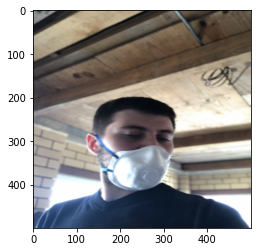

In [5]:
plt.imshow(images[5])

In [6]:
annotations = np.array(annotations)
len(images),len(annotations)

(629, 629)

In [7]:
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Rescaling,BatchNormalization,Reshape,Input
from tensorflow.keras.losses import MeanSquaredError
from keras.models import Model

In [16]:
inputs = Input(shape=(500,500,3))
x = Conv2D(16,(3,3),activation='relu')(inputs)
x = MaxPool2D()(x)

x = Conv2D(32,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(256,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

prediction = Dense(20,activation='linear')(x)
prediction = layers.Reshape((5,4))(prediction)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer = 'adam',loss = MeanSquaredError())
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 123, 123, 32)      128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 123, 123, 32)      0   

In [22]:
model.fit(images[:550],annotations[:550],epochs = 100)

Epoch 1/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0133
Epoch 2/100
18/18 [==============================] - 2s 95ms/step - loss: 0.0119
Epoch 3/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0110
Epoch 4/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0124
Epoch 5/100
18/18 [==============================] - 2s 107ms/step - loss: 0.0112
Epoch 6/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0115
Epoch 7/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0122
Epoch 8/100
18/18 [==============================] - 2s 98ms/step - loss: 0.0111
Epoch 9/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0125
Epoch 10/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0118
Epoch 11/100
18/18 [==============================] - 2s 105ms/step - loss: 0.0123
Epoch 12/100
18/18 [==============================] - 2s 101ms/step - loss: 0.0123
Epoch 13/100
18/18 [==

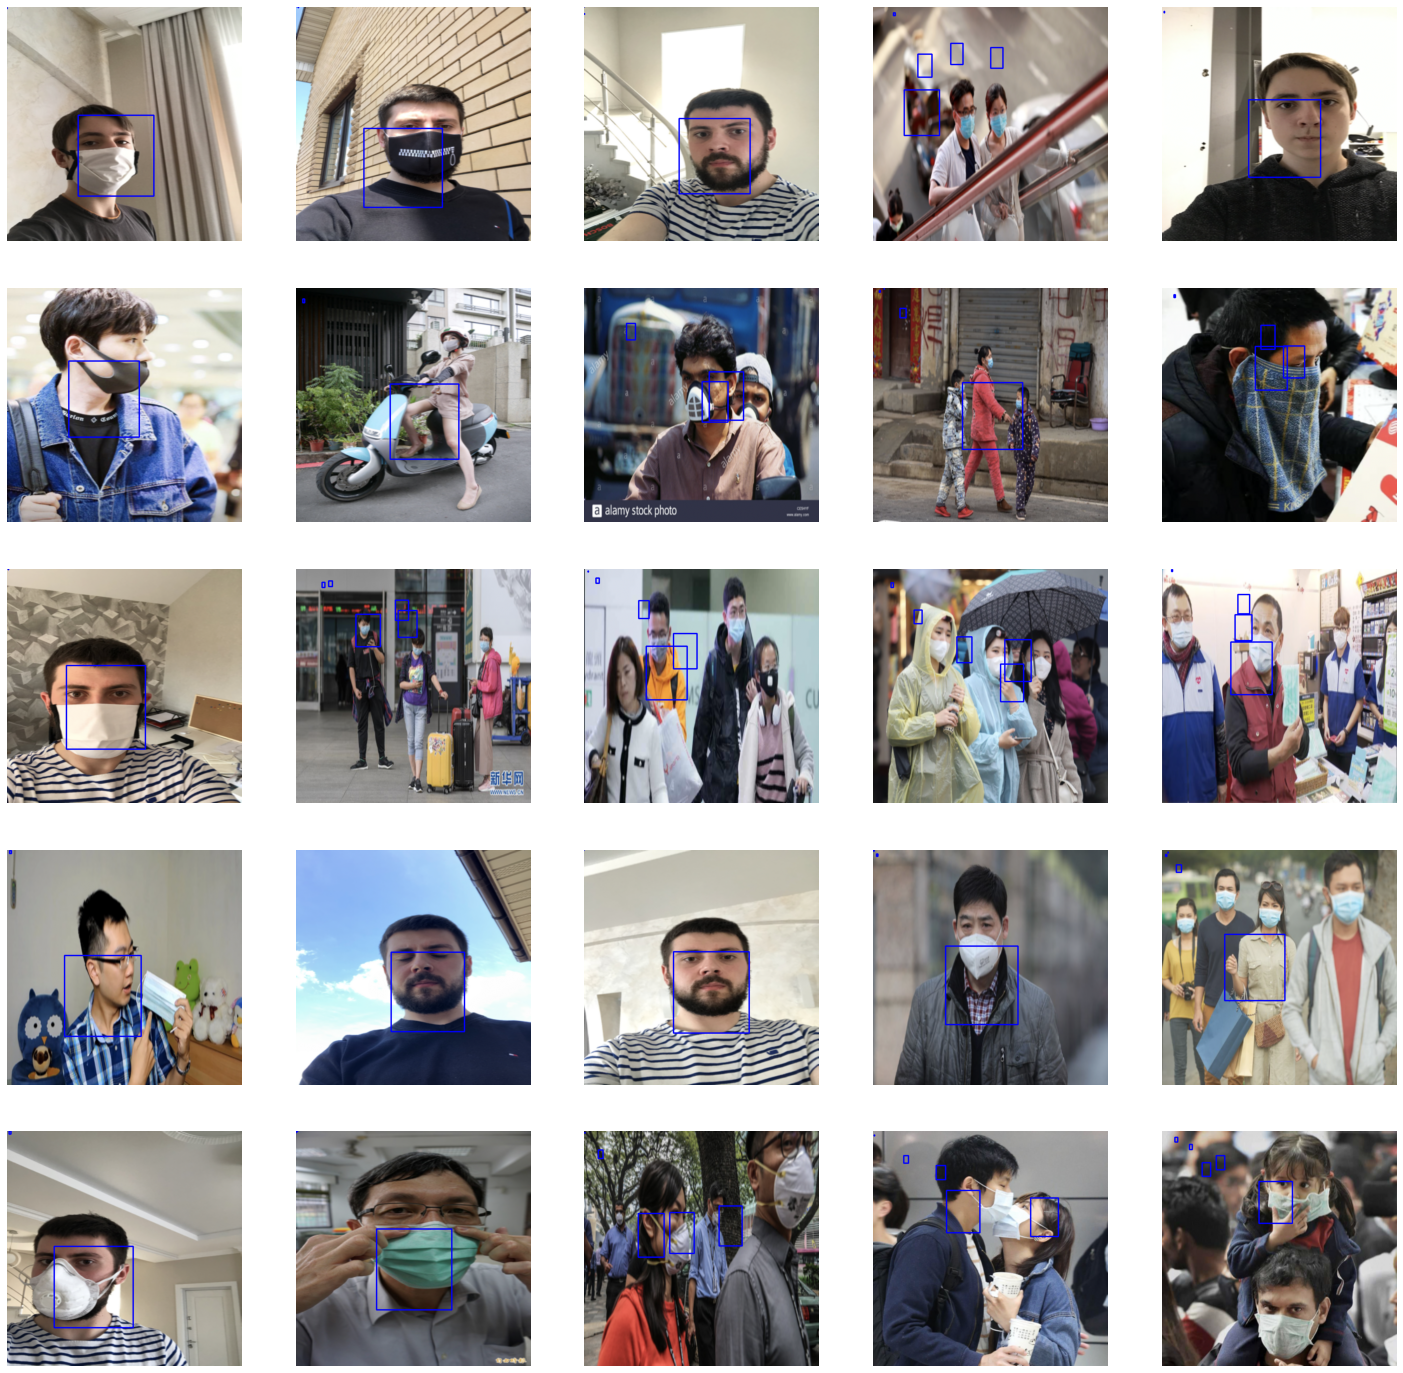

In [24]:
plt.figure(figsize=(25,25))
start= 600
end = 625
for i,img in enumerate(images[start:end].copy()):
    img = images[start].copy()

    predictions = model.predict(images[start].reshape(1,500,500,3))
    
    plt.subplot(5,5,i+1)
    for notations in predictions[0]:
        [xmin,ymin,xmax,ymax] = notations
        cv2.rectangle(img,(int(xmin*500),int(ymin*500)),(int(xmax*500),int(ymax*500)),(0,0,255),2)
    plt.imshow(img)
    plt.axis('off')
    start+=1

In [23]:
model.evaluate(images[550:],annotations[550:])

3/3 [==============================] - 0s 32ms/step - loss: 0.0359


0.03585193306207657

In [21]:
model.save('./detection.h5')